In [8]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [16]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 11.0 MB/s eta 0:00:000:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [48]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 12.9 MB/s eta 0:00:000:00:01


In [30]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/37b4d573-02a2-4c75-b69b-
[nltk_data]     8f21f8c5d212/nltk_data...


True

In [66]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/37b4d573-02a2-4c75-b69b-
[nltk_data]     8f21f8c5d212/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [54]:
!pip install NRCLex

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 9.2 MB/s eta 0:00:000:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43310 sha256=27e8a808fc106b3e1d3e39b7c48722be1b25c9c39594d3676d56b952ae6e4b1f
  Stored in directory: /home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex


In [60]:
import os
from multiprocessing import Pool
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import urllib.request
from collections import Counter
import itertools
from itertools import islice
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import nrclex

In [ ]:
from utils import read_file, clean_txt
from utils import stem_fun

In [24]:
file_path_data = os.path.abspath('Natural Language Processing/Group Project/covid_19_tweets.csv')
print(file_path_data)

/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Natural Language Processing/Group Project/covid_19_tweets.csv


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


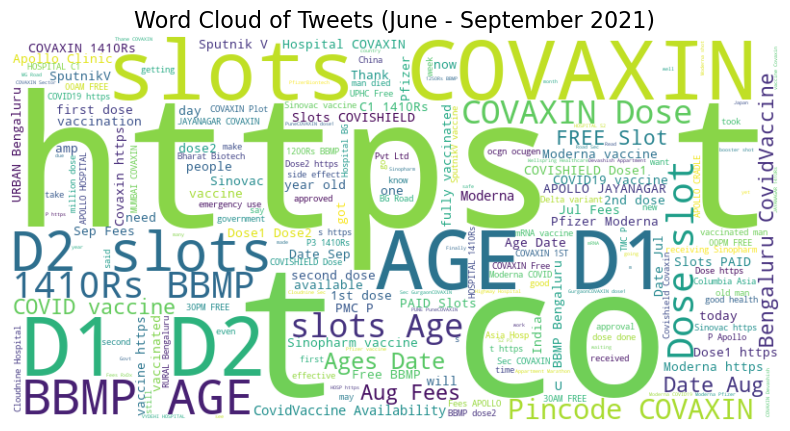

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


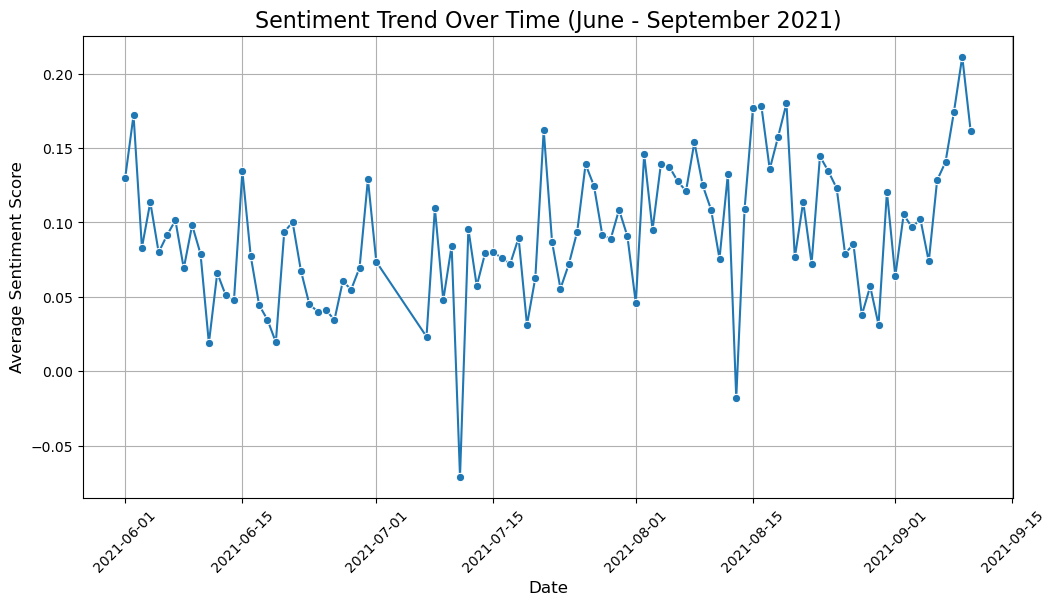

Average Sentiment Score (June - September 2021): 0.08320965201747624
Top 5 Most Positive Tweets:
                      date                                               text  \
274360 2021-06-09 13:32:24  Great Honor, Great Trust, Great Responsibility...   
332583 2021-08-02 08:00:41  Good to hear this positive and motivating news...   
312897 2021-07-14 11:27:34  Thank you #Moderna ! Fantastic process, Feel g...   
334578 2021-08-03 11:53:52  To the #900 heroes who took part in the #Sinop...   
335114 2021-08-03 16:15:09  @ProfessorCrunk Wow this tweet put me through ...   

        sentiment  
274360     0.9698  
332583     0.9655  
312897     0.9611  
334578     0.9595  
335114     0.9583  
Top 5 Most Negative Tweets:
                      date                                               text  \
271680 2021-06-07 17:29:18  why the fuck #Covaxin 2nd doze in delhi is so ...   
317340 2021-07-13 07:17:35  @sputnikvaccine has deleted all negative revie...   
296743 2021-06-29 11:46:2

In [32]:
# Load the dataset using the absolute path
df = pd.read_csv("/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Group Project/covid_19_tweets.csv")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the date range
start_date = "2021-06-01"
end_date = "2021-09-30"
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis
def vader_sentiment_score(row):
    text = row['text']  # Use the original text without cleaning
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return the compound sentiment score

# Function to apply sentiment analysis using parallel processing
def apply_sentiment_score(df):
    df['sentiment'] = df.apply(vader_sentiment_score, axis=1)
    return df

# Parallel processing function
def parallelize_dataframe(df, func, num_partitions=cpu_count()):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Apply sentiment analysis in parallel
filtered_df = parallelize_dataframe(filtered_df, apply_sentiment_score)

# Generate Word Cloud
all_text = ' '.join(filtered_df['text'].dropna())  # Combine all tweets into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets (June - September 2021)", fontsize=16)
plt.show()

# Analyze sentiment trends over time
filtered_df['date_only'] = filtered_df['date'].dt.date  # Extract the date only
sentiment_trend = filtered_df.groupby('date_only')['sentiment'].mean().reset_index()  # Calculate daily average sentiment

# Plot sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_trend, x='date_only', y='sentiment', marker='o')
plt.title("Sentiment Trend Over Time (June - September 2021)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Summary Statistics
average_sentiment = filtered_df['sentiment'].mean()
print(f"Average Sentiment Score (June - September 2021): {average_sentiment}")
print("Top 5 Most Positive Tweets:")
print(filtered_df.nlargest(5, 'sentiment')[['date', 'text', 'sentiment']])
print("Top 5 Most Negative Tweets:")
print(filtered_df.nsmallest(5, 'sentiment')[['date', 'text', 'sentiment']])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/37b4d573-02a2-4c75-b69b-
[nltk_data]     8f21f8c5d212/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


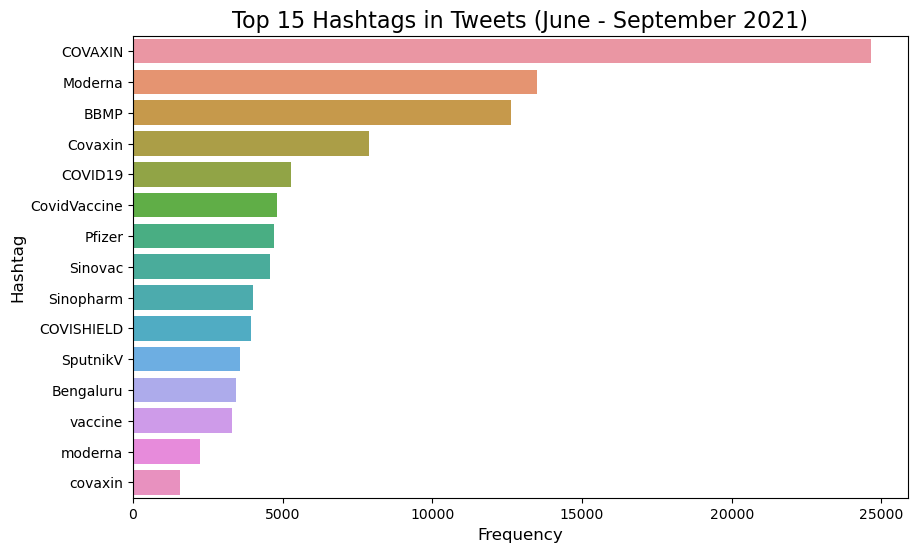

[nltk_data] Error loading nrc_lexicon: Package 'nrc_lexicon' not found
[nltk_data]     in index


ImportError: cannot import name 'nrc' from 'nltk.corpus' (/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/nltk/corpus/__init__.py)

In [42]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Load the dataset
df = pd.read_csv("/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Group Project/covid_19_tweets.csv")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the date range
start_date = "2021-06-01"
end_date = "2021-09-30"
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis
def vader_sentiment_score(row):
    text = row['text']  # Use the original text without cleaning
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return the compound sentiment score

# Apply sentiment analysis in parallel using multiprocessing
def apply_sentiment_score(df):
    df['sentiment'] = df.apply(vader_sentiment_score, axis=1)
    return df

def parallelize_dataframe(df, func, num_partitions=cpu_count()):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

filtered_df = parallelize_dataframe(filtered_df, apply_sentiment_score)

### Step 1: Hashtag Analysis ###
# Extract hashtags from the tweets
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

filtered_df['hashtags'] = filtered_df['text'].apply(lambda x: extract_hashtags(x))

# Flatten the list of lists of hashtags and count their frequency
all_hashtags = [hashtag for hashtags in filtered_df['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

# Plot the top 15 hashtags
top_hashtags = hashtag_counts.most_common(15)
hashtags, counts = zip(*top_hashtags)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(hashtags))
plt.title('Top 15 Hashtags in Tweets (June - September 2021)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Hashtag', fontsize=12)
plt.show()

### Step 2: Emotion Detection with NRC Lexicon ###
# Download NRC lexicon
nltk.download('nrc_lexicon')
from nltk.corpus import nrc

# Define emotions to analyze
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Define a function to assign emotions to text based on the NRC Lexicon
def emotion_analysis(text):
    words = text.split()
    emotion_count = Counter()
    for word in words:
        for emotion in emotions:
            if nrc.is_emotion(word, emotion):
                emotion_count[emotion] += 1
    return emotion_count

# Add emotion columns to the DataFrame
for emotion in emotions:
    filtered_df[emotion] = filtered_df['text'].apply(lambda x: emotion_analysis(x).get(emotion, 0))

# Calculate average emotional intensity
emotion_intensity = filtered_df[emotions].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_intensity.index, y=emotion_intensity.values)
plt.title('Average Emotional Intensity in Tweets (June - September 2021)', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.show()

### Step 3: Topic Modeling with LDA ###
# Text Preprocessing for LDA
stop_words = set(stopwords.words('english'))
filtered_df['cleaned_text'] = filtered_df['text'].apply(lambda x: re.sub(r'\b\d+\b|\W+', ' ', x.lower()))  # Lowercase and clean
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Vectorize the text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
text_data = vectorizer.fit_transform(filtered_df['cleaned_text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_data)

# Display the top words for each topic
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}: ", [words[i] for i in topic.argsort()[:-11:-1]])

### K-Means Clustering ###
# K-Means clustering to find tweet clusters
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_df['cluster'] = kmeans.fit_predict(text_data)

# Plot distribution of tweets across clusters
plt.figure(figsize=(10, 6))
sns.countplot(x=filtered_df['cluster'])
plt.title('Distribution of Tweets Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.show()

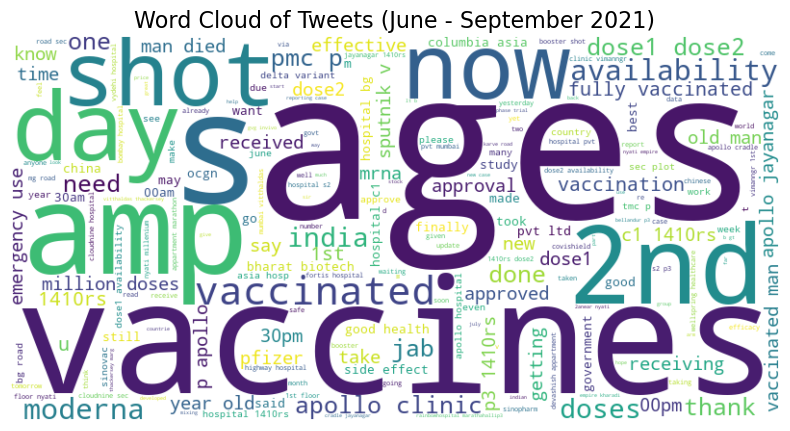

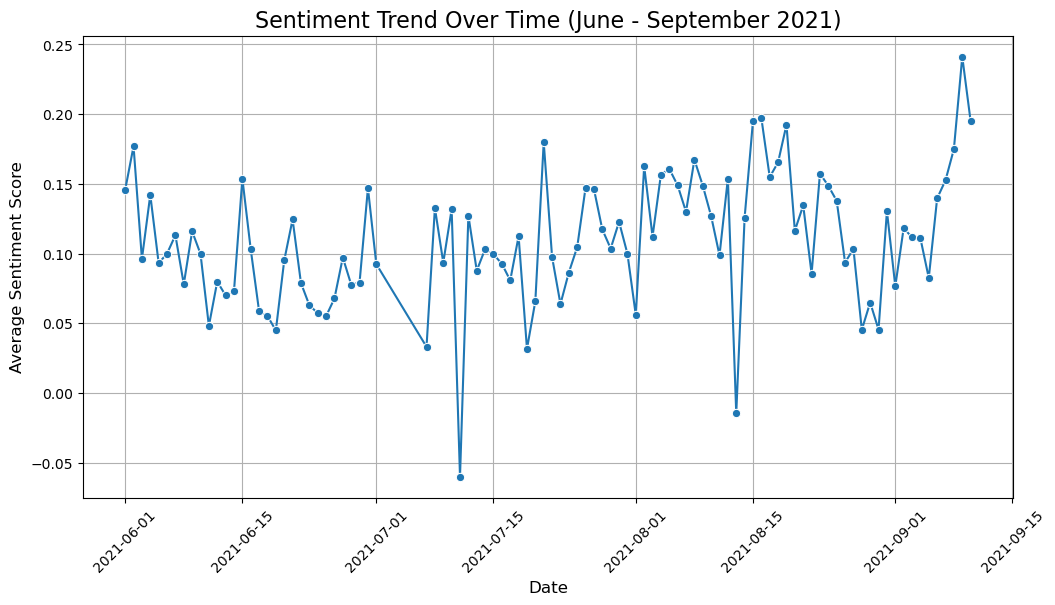

Average Sentiment Score (June - September 2021): 0.09948377486507325
Top 5 Most Positive Tweets:
                      date                                               text  \
296882 2021-06-29 15:55:21  Done ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅\n\n#Pfize...   
284923 2021-06-15 22:52:38  https://t.co/21rn64nCBK\n \nWhat gonna do $pfi...   
340599 2021-08-09 17:31:48  Don't have in their history !!! 🦍🦍🦍🦍👀🦍🦍🦍🦍😂😂😂😂😂...   
351709 2021-08-23 13:21:59  I'am so proud and Grateful! 😇🤗❤🙏 Cause i got m...   
308009 2021-07-10 05:36:38  @DinoRancho @TheJasonPugh @FP_Champagne @Ottaw...   

        sentiment  
296882     0.9943  
284923     0.9922  
340599     0.9895  
351709     0.9893  
308009     0.9855  
Top 5 Most Negative Tweets:
                      date                                               text  \
278839 2021-06-10 14:28:44  💢💢COVAXIN 2nd DOSE BANGALORE no registration I...   
358868 2021-08-31 03:51:35  Getting my second vaccine #Moderna tomorrow an...   
318619 2021-07-16 07:41:5

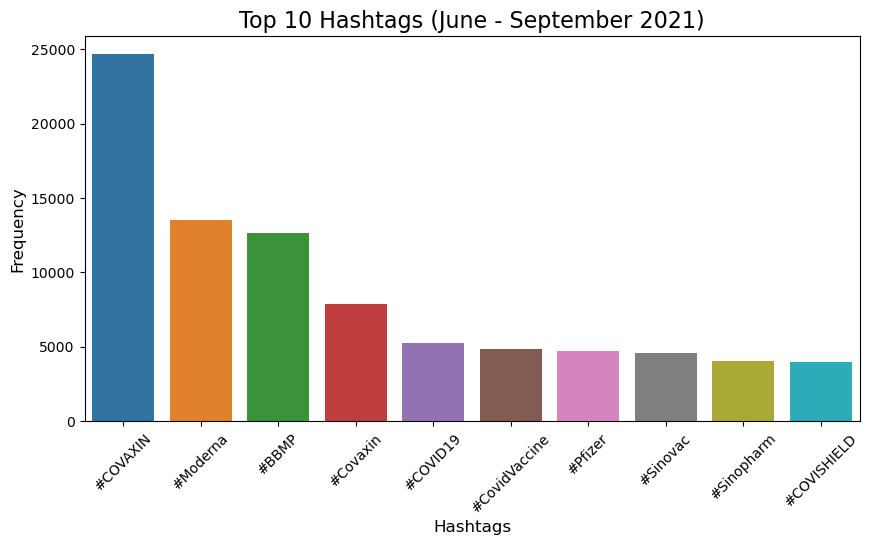

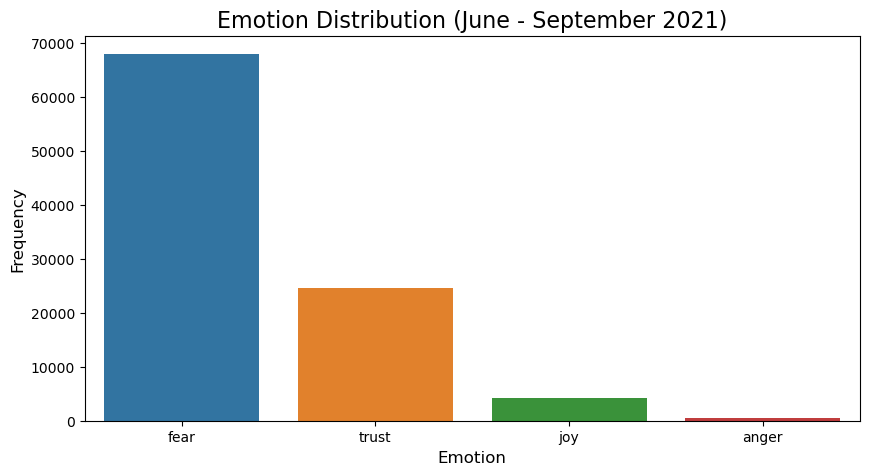

Top words for topic #0:
['vaccines', 'covid19', 'sinovac', 'pfizer', 'dose', 'covid', 'covaxin', 'vaccine', 'moderna', 'https']


Top words for topic #1:
['18', 'dose1', 'bengaluru', 'availability', 'free', 'covidvaccine', 'slots', 'covishield', 'covaxin', 'https']


Top words for topic #2:
['apollo', '08', 'dose1', 'pmc', 'clinic', 'dose2', '07', 'https', '2021', 'covaxin']


Top words for topic #3:
['dose', 'https', 'bbmp', 'd1', 'd2', '18', 'slots', '2021', 'age', 'covaxin']


Top words for topic #4:
['road', '14', 'dose1', '06', 'https', 'dose2', 'hospital', '07', '2021', 'covaxin']




/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


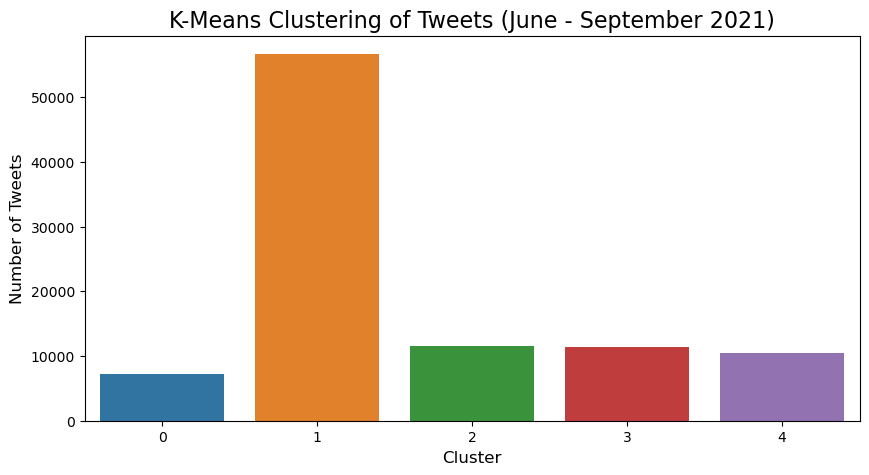

In [50]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

# Load the dataset using the absolute path
df = pd.read_csv("/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Group Project/covid_19_tweets.csv")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the date range
start_date = "2021-06-01"
end_date = "2021-09-30"
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis
def vader_sentiment_score(row):
    text = row['text']  # Use the original text without cleaning
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return the compound sentiment score

# Function to apply sentiment analysis using parallel processing
def apply_sentiment_score(df):
    df['sentiment'] = df.apply(vader_sentiment_score, axis=1)
    return df

# Parallel processing function
def parallelize_dataframe(df, func, num_partitions=cpu_count()):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Apply sentiment analysis in parallel
filtered_df = parallelize_dataframe(filtered_df, apply_sentiment_score)

# Preprocess text for the word cloud (removing URLs, mentions, hashtags, numbers, and unnecessary words)
def clean_text_for_wordcloud(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Combine all tweets and clean the text for the word cloud
all_text = ' '.join(filtered_df['text'].dropna().apply(clean_text_for_wordcloud))

# Add custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['age', 'slot', 'slots', 'dose', 'covaxin', 'd1', 'd2', 'date', 'vaccine', 
                         'available', 'free', 'paid', 'pincode', 'covid', 'fees', 'first', 
                         'second', 'aug', 'jul', 'sep', 'today', 'people', 'will', 'got'])

# Generate Word Cloud with custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_text)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets (June - September 2021)", fontsize=16)
plt.show()

# Analyze sentiment trends over time
filtered_df['date_only'] = filtered_df['date'].dt.date  # Extract the date only
sentiment_trend = filtered_df.groupby('date_only')['sentiment'].mean().reset_index()  # Calculate daily average sentiment

# Plot sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_trend, x='date_only', y='sentiment', marker='o')
plt.title("Sentiment Trend Over Time (June - September 2021)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Summary Statistics
average_sentiment = filtered_df['sentiment'].mean()
print(f"Average Sentiment Score (June - September 2021): {average_sentiment}")
print("Top 5 Most Positive Tweets:")
print(filtered_df.nlargest(5, 'sentiment')[['date', 'text', 'sentiment']])
print("Top 5 Most Negative Tweets:")
print(filtered_df.nsmallest(5, 'sentiment')[['date', 'text', 'sentiment']])

# ---------------------- Hashtag Analysis ----------------------
filtered_df['hashtags'] = filtered_df['text'].apply(lambda x: re.findall(r'#\w+', x))
hashtag_series = pd.Series([hashtag for hashtags in filtered_df['hashtags'] for hashtag in hashtags])
top_hashtags = hashtag_series.value_counts().head(10)

# Plot Top Hashtags
plt.figure(figsize=(10, 5))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values)
plt.title("Top 10 Hashtags (June - September 2021)", fontsize=16)
plt.xlabel("Hashtags", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# ---------------------- Emotion Detection ----------------------
from nltk.corpus import stopwords
from textblob import TextBlob

# Install NRC Emotion Lexicon if necessary (not available in NLTK by default)
# Using TextBlob as an alternative for a simple emotional analysis
def detect_emotion(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.5:
        return "joy"
    elif polarity < -0.5:
        return "anger"
    elif polarity > 0:
        return "trust"
    else:
        return "fear"

filtered_df['emotion'] = filtered_df['text'].apply(detect_emotion)
emotion_counts = filtered_df['emotion'].value_counts()

# Plot Emotion Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Emotion Distribution (June - September 2021)", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# ---------------------- Topic Modeling with LDA ----------------------
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(filtered_df['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display the topics with their top words
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([words[i] for i in topic.argsort()[-10:]])
    print("\n")

# ---------------------- K-Means Clustering ----------------------
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(filtered_df['text'])
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Plot Cluster Sizes
plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', data=filtered_df)
plt.title("K-Means Clustering of Tweets (June - September 2021)", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.show()

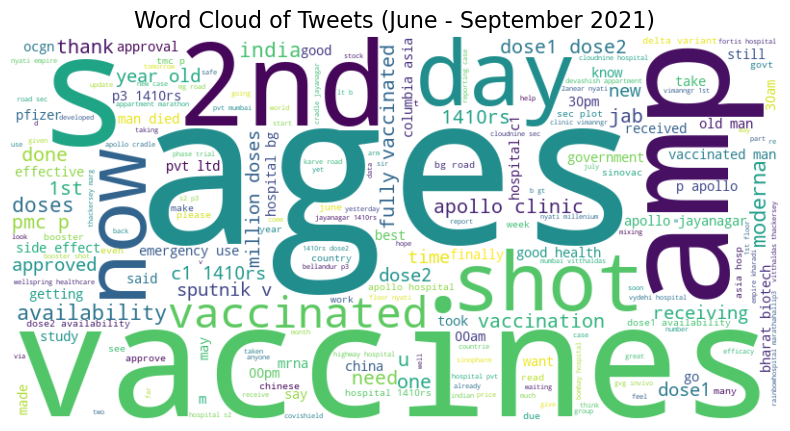

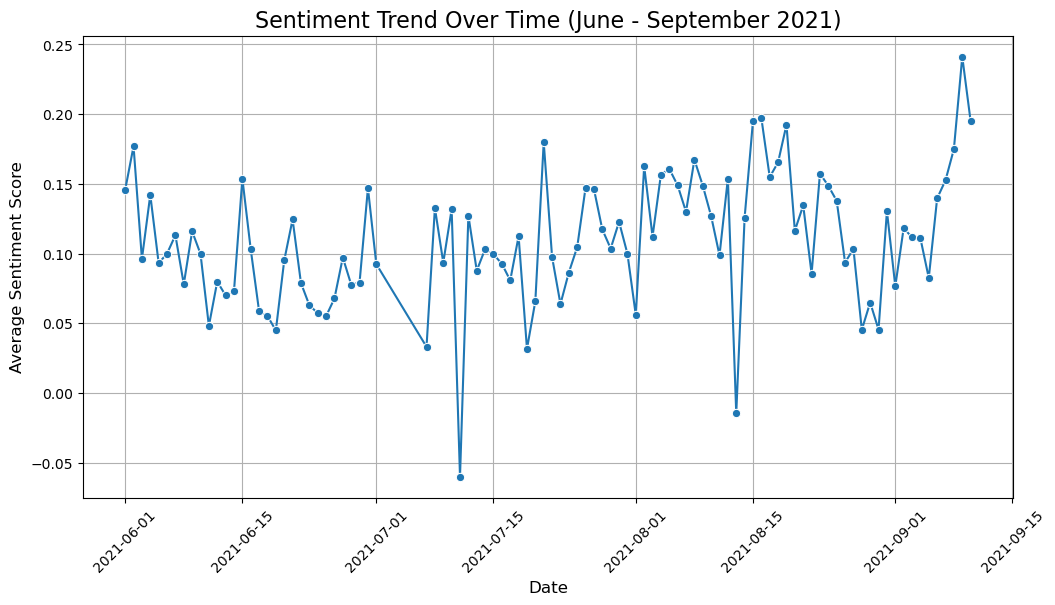

Average Sentiment Score (June - September 2021): 0.09948377486507325
Top 5 Most Positive Tweets:
                      date                                               text  \
296882 2021-06-29 15:55:21  Done ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅\n\n#Pfize...   
284923 2021-06-15 22:52:38  https://t.co/21rn64nCBK\n \nWhat gonna do $pfi...   
340599 2021-08-09 17:31:48  Don't have in their history !!! 🦍🦍🦍🦍👀🦍🦍🦍🦍😂😂😂😂😂...   
351709 2021-08-23 13:21:59  I'am so proud and Grateful! 😇🤗❤🙏 Cause i got m...   
308009 2021-07-10 05:36:38  @DinoRancho @TheJasonPugh @FP_Champagne @Ottaw...   

        sentiment  
296882     0.9943  
284923     0.9922  
340599     0.9895  
351709     0.9893  
308009     0.9855  
Top 5 Most Negative Tweets:
                      date                                               text  \
278839 2021-06-10 14:28:44  💢💢COVAXIN 2nd DOSE BANGALORE no registration I...   
358868 2021-08-31 03:51:35  Getting my second vaccine #Moderna tomorrow an...   
318619 2021-07-16 07:41:5

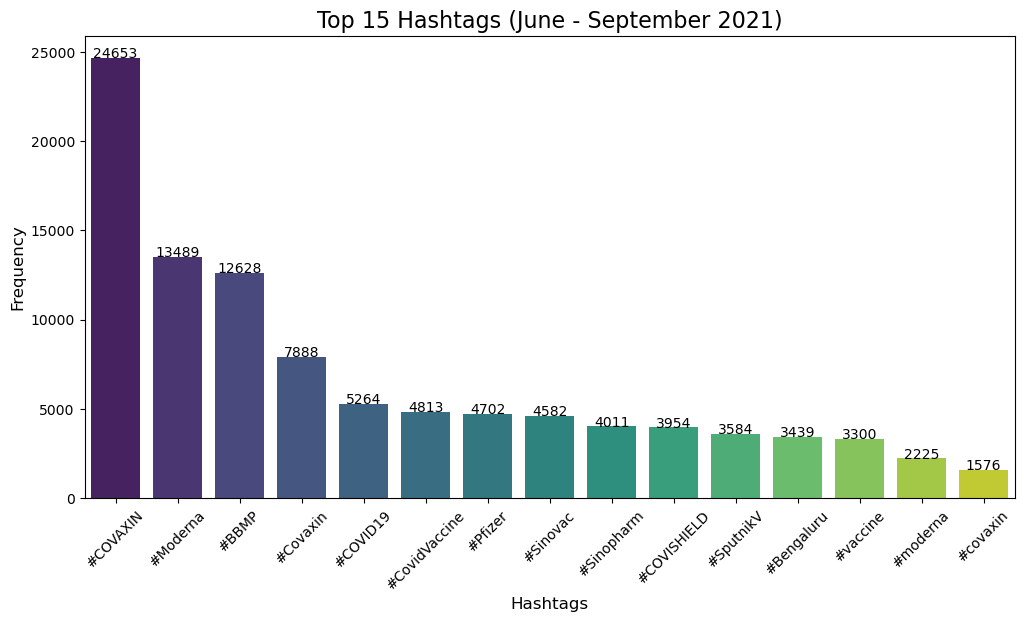

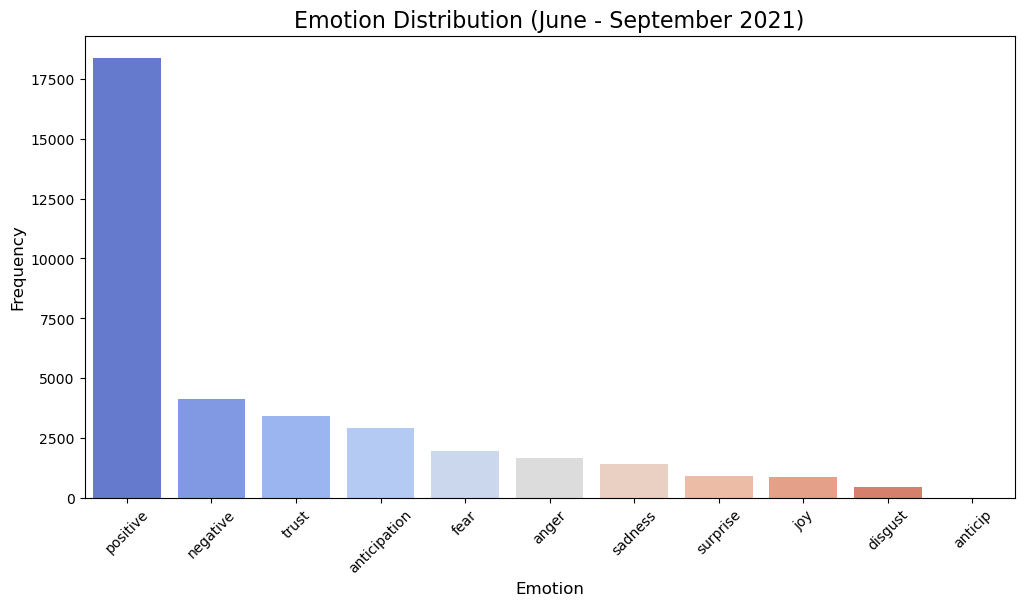

Top words for topic #0:
['vaccines', 'covid19', 'sinovac', 'pfizer', 'dose', 'covid', 'covaxin', 'vaccine', 'moderna', 'https']


Top words for topic #1:
['18', 'dose1', 'bengaluru', 'availability', 'free', 'covidvaccine', 'slots', 'covishield', 'covaxin', 'https']


Top words for topic #2:
['apollo', '08', 'dose1', 'pmc', 'clinic', 'dose2', '07', 'https', '2021', 'covaxin']


Top words for topic #3:
['dose', 'https', 'bbmp', 'd1', 'd2', '18', 'slots', '2021', 'age', 'covaxin']


Top words for topic #4:
['road', '14', 'dose1', '06', 'https', 'dose2', 'hospital', '07', '2021', 'covaxin']




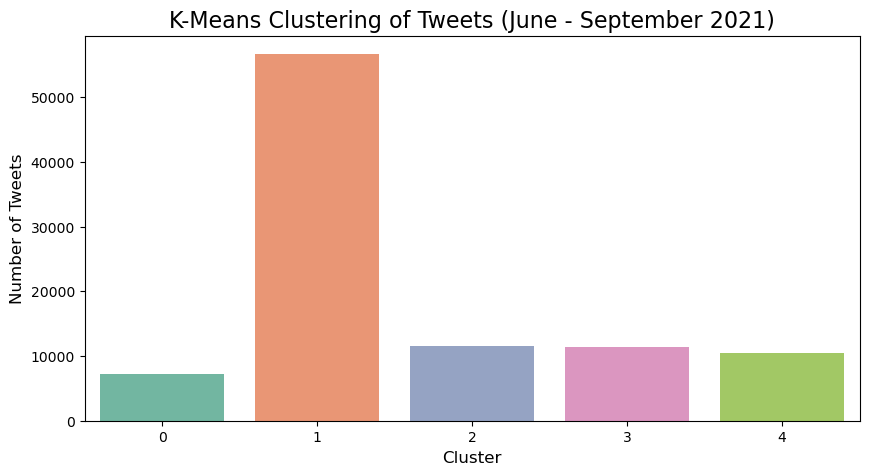

In [68]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from nrclex import NRCLex

# Load the dataset using the absolute path
df = pd.read_csv("/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Group Project/covid_19_tweets.csv")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the date range
start_date = "2021-06-01"
end_date = "2021-09-30"
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis
def vader_sentiment_score(row):
    text = row['text']  # Use the original text without cleaning
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return the compound sentiment score

# Function to apply sentiment analysis using parallel processing
def apply_sentiment_score(df):
    df['sentiment'] = df.apply(vader_sentiment_score, axis=1)
    return df

# Parallel processing function
def parallelize_dataframe(df, func, num_partitions=cpu_count()):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Apply sentiment analysis in parallel
filtered_df = parallelize_dataframe(filtered_df, apply_sentiment_score)

# Preprocess text for the word cloud (removing URLs, mentions, hashtags, numbers, and unnecessary words)
def clean_text_for_wordcloud(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Combine all tweets and clean the text for the word cloud
all_text = ' '.join(filtered_df['text'].dropna().apply(clean_text_for_wordcloud))

# Add custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['age', 'slot', 'slots', 'dose', 'covaxin', 'd1', 'd2', 'date', 'vaccine', 
                         'available', 'free', 'paid', 'pincode', 'covid', 'fees', 'first', 
                         'second', 'aug', 'jul', 'sep', 'today', 'people', 'will', 'got'])

# Generate Word Cloud with custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_text)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets (June - September 2021)", fontsize=16)
plt.show()

# Analyze sentiment trends over time
filtered_df['date_only'] = filtered_df['date'].dt.date  # Extract the date only
sentiment_trend = filtered_df.groupby('date_only')['sentiment'].mean().reset_index()  # Calculate daily average sentiment

# Plot sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_trend, x='date_only', y='sentiment', marker='o')
plt.title("Sentiment Trend Over Time (June - September 2021)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Summary Statistics
average_sentiment = filtered_df['sentiment'].mean()
print(f"Average Sentiment Score (June - September 2021): {average_sentiment}")
print("Top 5 Most Positive Tweets:")
print(filtered_df.nlargest(5, 'sentiment')[['date', 'text', 'sentiment']])
print("Top 5 Most Negative Tweets:")
print(filtered_df.nsmallest(5, 'sentiment')[['date', 'text', 'sentiment']])

# ---------------------- Hashtag Analysis ----------------------
filtered_df['hashtags'] = filtered_df['text'].apply(lambda x: re.findall(r'#\w+', x))
hashtag_series = pd.Series([hashtag for hashtags in filtered_df['hashtags'] for hashtag in hashtags])
top_hashtags = hashtag_series.value_counts().head(15)

# Plot Top 15 Hashtags
plt.figure(figsize=(12, 6))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values, palette='viridis')
plt.title("Top 15 Hashtags (June - September 2021)", fontsize=16)
plt.xlabel("Hashtags", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
# Add value labels to each bar
for index, value in enumerate(top_hashtags.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10)
plt.show()

# ---------------------- Emotion Detection using NRClex ----------------------
def detect_emotions_nrc(text):
    nrc = NRCLex(text)
    return nrc.top_emotions

filtered_df['emotions'] = filtered_df['text'].apply(lambda x: dict(detect_emotions_nrc(x)))
emotions_summary = pd.DataFrame(filtered_df['emotions'].tolist()).sum().sort_values(ascending=False)

# Plot Emotion Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=emotions_summary.index, y=emotions_summary.values, palette='coolwarm')
plt.title("Emotion Distribution (June - September 2021)", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# ---------------------- Topic Modeling with LDA ----------------------
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(filtered_df['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display the topics with their top words
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([words[i] for i in topic.argsort()[-10:]])
    print("\n")

# ---------------------- K-Means Clustering ----------------------
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(filtered_df['text'])
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Plot Cluster Sizes
plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', data=filtered_df, palette='Set2')
plt.title("K-Means Clustering of Tweets (June - September 2021)", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.show()

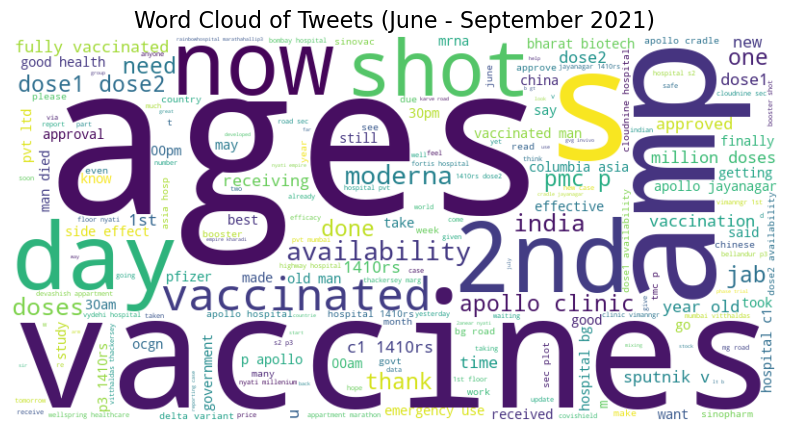

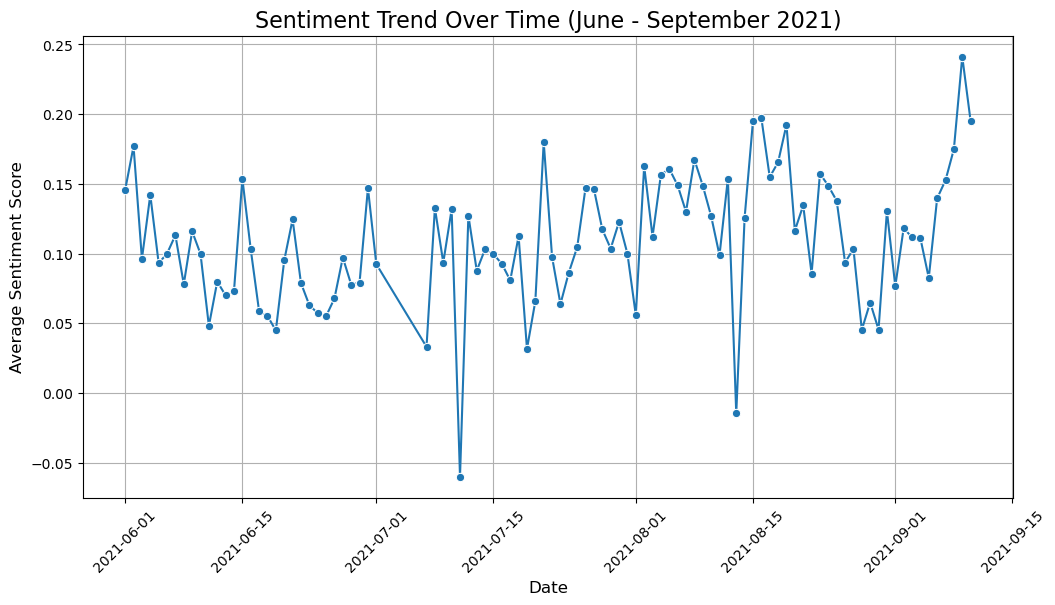

Average Sentiment Score (June - September 2021): 0.09948377486507325
Top 5 Most Positive Tweets:
                      date                                               text  \
296882 2021-06-29 15:55:21  Done ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅\n\n#Pfize...   
284923 2021-06-15 22:52:38  https://t.co/21rn64nCBK\n \nWhat gonna do $pfi...   
340599 2021-08-09 17:31:48  Don't have in their history !!! 🦍🦍🦍🦍👀🦍🦍🦍🦍😂😂😂😂😂...   
351709 2021-08-23 13:21:59  I'am so proud and Grateful! 😇🤗❤🙏 Cause i got m...   
308009 2021-07-10 05:36:38  @DinoRancho @TheJasonPugh @FP_Champagne @Ottaw...   

        sentiment  
296882     0.9943  
284923     0.9922  
340599     0.9895  
351709     0.9893  
308009     0.9855  
Top 5 Most Negative Tweets:
                      date                                               text  \
278839 2021-06-10 14:28:44  💢💢COVAXIN 2nd DOSE BANGALORE no registration I...   
358868 2021-08-31 03:51:35  Getting my second vaccine #Moderna tomorrow an...   
318619 2021-07-16 07:41:5

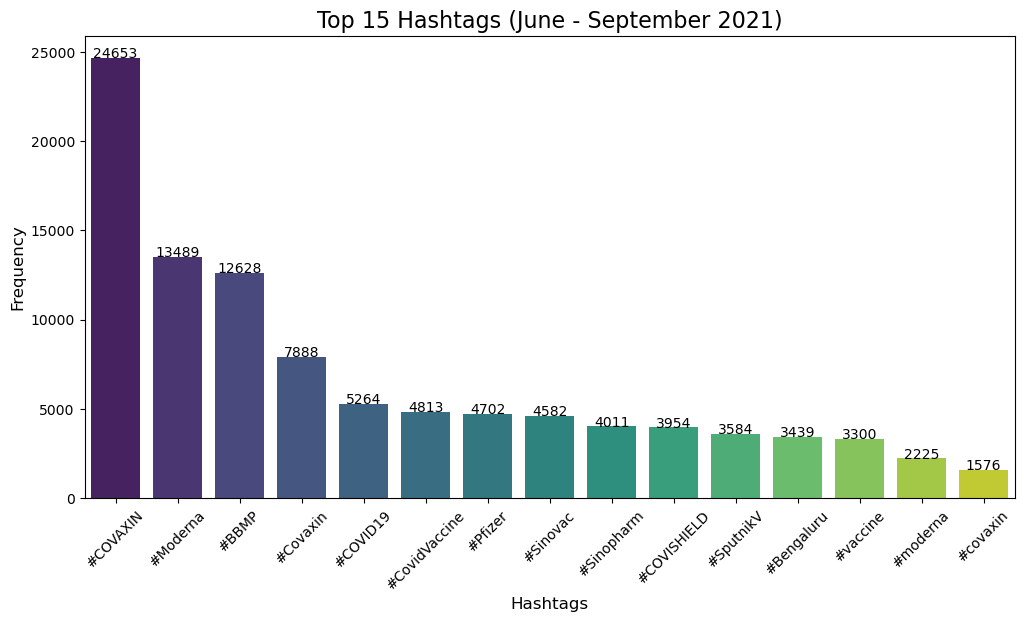

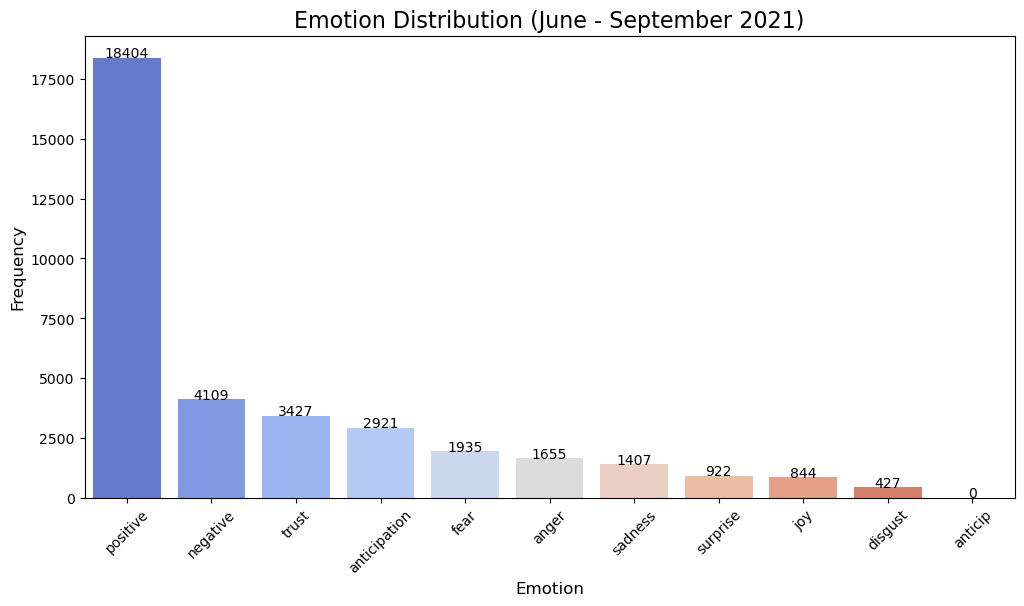

Top words for topic #0:
['vaccines', 'covid19', 'sinovac', 'pfizer', 'dose', 'covid', 'covaxin', 'vaccine', 'moderna', 'https']


Top words for topic #1:
['18', 'dose1', 'bengaluru', 'availability', 'free', 'covidvaccine', 'slots', 'covishield', 'covaxin', 'https']


Top words for topic #2:
['apollo', '08', 'dose1', 'pmc', 'clinic', 'dose2', '07', 'https', '2021', 'covaxin']


Top words for topic #3:
['dose', 'https', 'bbmp', 'd1', 'd2', '18', 'slots', '2021', 'age', 'covaxin']


Top words for topic #4:
['road', '14', 'dose1', '06', 'https', 'dose2', 'hospital', '07', '2021', 'covaxin']




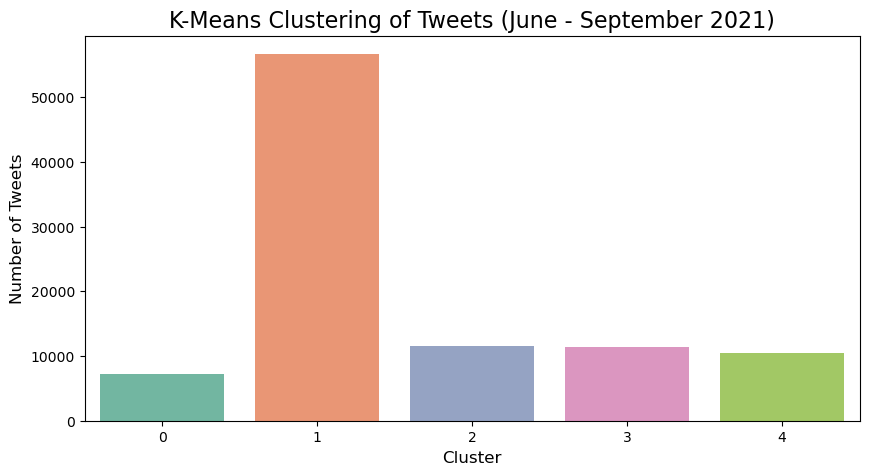

In [73]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from nrclex import NRCLex

# Load the dataset using the absolute path
df = pd.read_csv("/home/37b4d573-02a2-4c75-b69b-8f21f8c5d212/Natural Language Processing/Group Project/covid_19_tweets.csv")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the date range
start_date = "2021-06-01"
end_date = "2021-09-30"
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis
def vader_sentiment_score(row):
    text = row['text']  # Use the original text without cleaning
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return the compound sentiment score

# Function to apply sentiment analysis using parallel processing
def apply_sentiment_score(df):
    df['sentiment'] = df.apply(vader_sentiment_score, axis=1)
    return df

# Parallel processing function
def parallelize_dataframe(df, func, num_partitions=cpu_count()):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Apply sentiment analysis in parallel
filtered_df = parallelize_dataframe(filtered_df, apply_sentiment_score)

# Preprocess text for the word cloud (removing URLs, mentions, hashtags, numbers, and unnecessary words)
def clean_text_for_wordcloud(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Combine all tweets and clean the text for the word cloud
all_text = ' '.join(filtered_df['text'].dropna().apply(clean_text_for_wordcloud))

# Add custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['age', 'slot', 'slots', 'dose', 'covaxin', 'd1', 'd2', 'date', 'vaccine', 
                         'available', 'free', 'paid', 'pincode', 'covid', 'fees', 'first', 
                         'second', 'aug', 'jul', 'sep', 'today', 'people', 'will', 'got'])

# Generate Word Cloud with custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_text)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets (June - September 2021)", fontsize=16)
plt.show()

# Analyze sentiment trends over time
filtered_df['date_only'] = filtered_df['date'].dt.date  # Extract the date only
sentiment_trend = filtered_df.groupby('date_only')['sentiment'].mean().reset_index()  # Calculate daily average sentiment

# Plot sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_trend, x='date_only', y='sentiment', marker='o')
plt.title("Sentiment Trend Over Time (June - September 2021)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Summary Statistics
average_sentiment = filtered_df['sentiment'].mean()
print(f"Average Sentiment Score (June - September 2021): {average_sentiment}")
print("Top 5 Most Positive Tweets:")
print(filtered_df.nlargest(5, 'sentiment')[['date', 'text', 'sentiment']])
print("Top 5 Most Negative Tweets:")
print(filtered_df.nsmallest(5, 'sentiment')[['date', 'text', 'sentiment']])

# ---------------------- Hashtag Analysis ----------------------
filtered_df['hashtags'] = filtered_df['text'].apply(lambda x: re.findall(r'#\w+', x))
hashtag_series = pd.Series([hashtag for hashtags in filtered_df['hashtags'] for hashtag in hashtags])
top_hashtags = hashtag_series.value_counts().head(15)

# Plot Top 15 Hashtags
plt.figure(figsize=(12, 6))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values, palette='viridis')
plt.title("Top 15 Hashtags (June - September 2021)", fontsize=16)
plt.xlabel("Hashtags", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
# Add value labels to each bar
for index, value in enumerate(top_hashtags.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10)
plt.show()

# ---------------------- Emotion Detection using NRClex ----------------------
def detect_emotions_nrc(text):
    nrc = NRCLex(text)
    return nrc.top_emotions

filtered_df['emotions'] = filtered_df['text'].apply(lambda x: dict(detect_emotions_nrc(x)))
emotions_summary = pd.DataFrame(filtered_df['emotions'].tolist()).sum().sort_values(ascending=False).apply(np.ceil)

# Plot Emotion Distribution with Labels
plt.figure(figsize=(12, 6))
sns.barplot(x=emotions_summary.index, y=emotions_summary.values, palette='coolwarm')
plt.title("Emotion Distribution (June - September 2021)", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)

# Add value labels to each bar (rounded up to nearest integer)
for index, value in enumerate(emotions_summary.values):
    plt.text(index, value + 5, str(int(value)), ha='center', fontsize=10)

plt.show()

# ---------------------- Topic Modeling with LDA ----------------------
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(filtered_df['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display the topics with their top words
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([words[i] for i in topic.argsort()[-10:]])
    print("\n")

# ---------------------- K-Means Clustering ----------------------
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(filtered_df['text'])
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Plot Cluster Sizes
plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', data=filtered_df, palette='Set2')
plt.title("K-Means Clustering of Tweets (June - September 2021)", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.show()